In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as smi
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from statistics import mean
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, SimpleRNN, GRU, Dropout, Conv1D, MaxPooling1D, Flatten, RepeatVector
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error, mean_absolute_error
from tensorflow.keras.optimizers import Adam, Nadam, RMSprop
from statsmodels.tsa.seasonal import seasonal_decompose
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from hyperopt import hp, Trials, fmin, tpe
import joblib
import warnings
warnings.simplefilter('ignore')

In [3]:
df=pd.read_csv(r'Niftymultifatorinput_with sensex and bank nifty data.csv')
df.tail()

,Date,NIFTY,Crude Oil,India VIX,INRUSD,Gold,S & P 500,Sensex,NIFTY BANK
3669,12/22/2023,21349.40039,73.559998,13.7075,83.13,2057.1,4754.63,71106.96094,47491.85
3670,12/26/2023,21441.35000,75.570000,14.6775,83.17,2058.2,4774.75,71336.80000,47724.85
3671,12/27/2023,21654.75000,74.110000,15.5575,83.18,2081.9,4781.58,72038.43000,48282.20
3672,12/28/2023,21778.30000,71.770000,15.1400,83.27,2073.9,4783.35,72410.38000,48508.55
3673,12/29/2023,21731.40000,71.650000,14.5025,83.30,2062.4,4769.83,72240.26000,48292.25


In [3]:
#RSI
def rsi(close, lookback=14):
    # Calculate price differences
    close_diff = close.diff()

    # Separate gains and losses
    gains = close_diff.clip(lower=0)
    losses = -close_diff.clip(upper=0)

    # Calculate exponential moving averages (EMA) of gains and losses
    avg_gain = gains.ewm(span=lookback, min_periods=lookback - 1).mean()
    avg_loss = losses.ewm(span=lookback, min_periods=lookback - 1).mean()

    # Calculate the Relative Strength (RS)
    rs = avg_gain / avg_loss

    # Calculate the Relative Strength Index (RSI)
    rsi = 100 - (100 / (1 + rs))
    return rsi
close= df['NIFTY']
rsi_values = rsi(close)
df['RSI'] = df.index.map(rsi_values)
pd.set_option("display.max_columns", None)

#MACD
k = df['NIFTY'].ewm(span=12, adjust=False, min_periods=12).mean()# Get the 26-day EMA of the NIFTY 50 closing price
d = df['NIFTY'].ewm(span=26, adjust=False, min_periods=26).mean()# Get the 12-day EMA of the NIFTY 50 closing price

macd = k - d # Subtract the 26-day EMA from the 12-day EMA to get the MACD
df['MACD'] = df.index.map(macd)

# View our data
pd.set_option("display.max_columns", None)
df=df.dropna()
df.head(5)

,Date,NIFTY,Crude Oil,India VIX,INRUSD,Gold,S & P 500,Sensex,NIFTY BANK,RSI,MACD
25,2/10/2009,2934.500000,37.549999,44.30,48.59,913.7,827.16,9647.469727,4515.80,65.159805,-17.684037
26,2/11/2009,2925.699951,35.939999,46.65,48.61,943.8,833.74,9618.540039,4504.30,63.354593,-9.699224
27,2/12/2009,2893.050049,33.980000,45.65,48.75,948.5,835.19,9465.830078,4468.35,56.637284,-5.937334
28,2/13/2009,2948.350098,37.509998,43.31,48.76,941.5,826.84,9634.740234,4565.85,64.080194,1.489077
29,2/16/2009,2848.500000,34.930000,42.56,48.72,953.5,808.01,9305.450195,4351.45,47.201095,-0.674729


In [4]:
feature_columns = ['NIFTY', 'Crude Oil', 'India VIX', 'Gold', 'RSI', 'MACD', 'INRUSD', 'S & P 500']
target_column = ['NIFTY']
features = df[feature_columns]
target = df[target_column].shift(-1)
y=target=target.dropna()

X=features =df[feature_columns].head(-1)
features.tail(5)

,NIFTY,Crude Oil,India VIX,Gold,RSI,MACD,INRUSD,S & P 500
3668,21255.05078,73.889999,13.7575,2039.1,65.173117,414.957124,83.27,4746.75
3669,21349.40039,73.559998,13.7075,2057.1,68.674714,406.849869,83.13,4754.63
3670,21441.35000,75.570000,14.6775,2058.2,71.856609,403.196577,83.17,4774.75
3671,21654.75000,74.110000,15.5575,2081.9,77.874848,412.762841,83.18,4781.58
3672,21778.30000,71.770000,15.1400,2073.9,80.640421,425.409767,83.27,4783.35


In [5]:
target.tail(5)

,NIFTY
3668,21349.40039
3669,21441.35000
3670,21654.75000
3671,21778.30000
3672,21731.40000


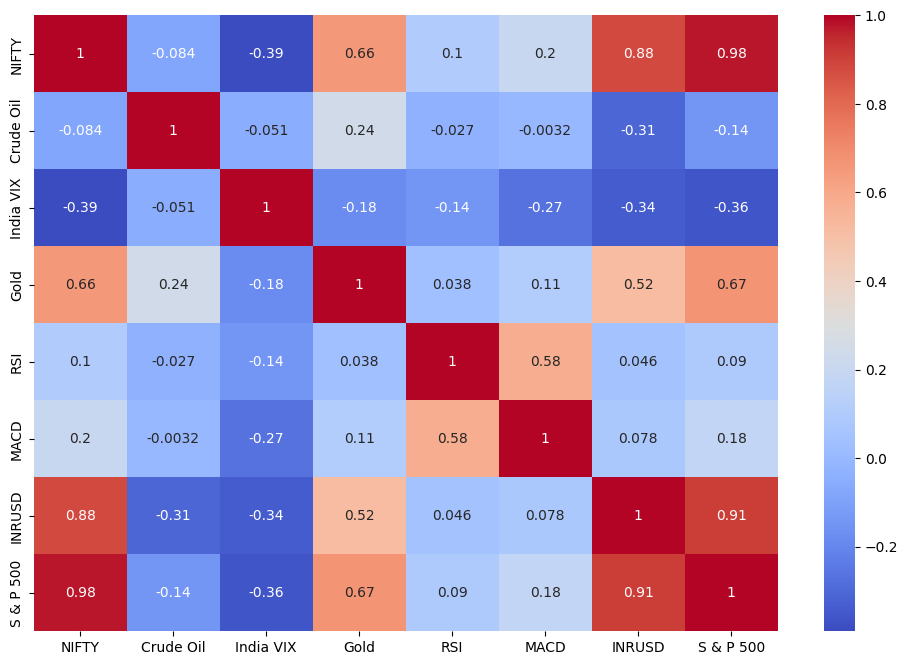

In [6]:
correlation = features.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation, annot=True, cmap='coolwarm')
#plt.title('Correlation Heatmap among external influencing factors')
plt.savefig('Correlation Heatmap among external influencing factors.png', dpi=900)  # Saves the plot as a PNG/JPG file
plt.show()

Feature Selection Results:
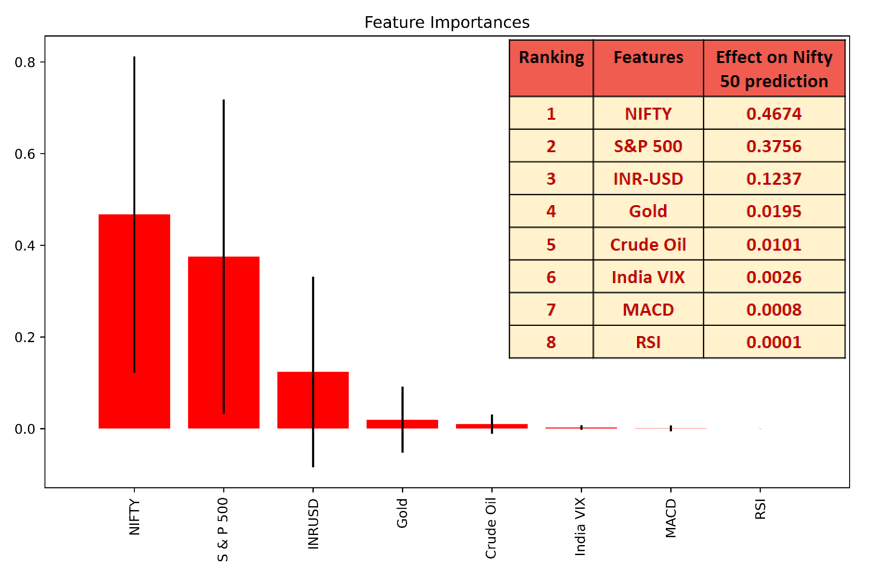

In [9]:
df=pd.read_csv(r'Niftymultifatorinput_with sensex and bank nifty data.csv')
df.head()

,Date,NIFTY,Crude Oil,India VIX,INRUSD,Gold,S & P 500,Sensex,NIFTY BANK
0,1/2/2009,3046.750000,46.340000,40.67,48.24,878.8,931.80,9958.219727,5195.10
1,1/5/2009,3121.449951,48.810001,38.60,48.23,857.2,927.45,10275.599610,5359.40
2,1/6/2009,3112.800049,48.580002,38.73,48.51,865.4,934.70,10335.929690,5395.30
3,1/7/2009,2920.399902,42.630001,44.36,48.55,841.1,906.65,9586.879883,4984.55
4,1/9/2009,2873.000000,41.700001,47.82,48.47,854.3,890.35,9406.469727,4906.70


In [10]:
feature_columns = ['NIFTY', 'INRUSD', 'S & P 500']
target_column = ['NIFTY']
features = df[feature_columns]
target = df[target_column].shift(-1)
target=target.dropna()

features =df[feature_columns].head(-1)
features.tail(5)

,NIFTY,INRUSD,S & P 500
3668,21255.05078,83.27,4746.75
3669,21349.40039,83.13,4754.63
3670,21441.35000,83.17,4774.75
3671,21654.75000,83.18,4781.58
3672,21778.30000,83.27,4783.35


In [11]:
target.tail()

,NIFTY
3668,21349.40039
3669,21441.35000
3670,21654.75000
3671,21778.30000
3672,21731.40000


In [12]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_features = scaler.fit_transform(features)
scaled_target = scaler.fit_transform(target.values.reshape(-1, 1))

n_steps = 5  # Number of timesteps to look back
X, y = [], []

for i in range(n_steps, len(scaled_features)):
    X.append(scaled_features[i-n_steps:i])
    y.append(scaled_target[i])

X = np.array(X)
y = np.array(y)

split=int(0.80*len(X))
X_train, y_train= X[:split], y[:split]
X_test, y_test= X[split:], y[split:]

In [13]:
#load saved LSTM 1 layer best model
model_lstm = load_model('model_ET_sp-usdinr_lstm1_0.9752.keras')

model_lstm.predict(X_test)
predictions_lstm = model_lstm.predict(X_test)
predictions_LSTM = scaler.inverse_transform(predictions_lstm)
y_test_actual_LSTM = scaler.inverse_transform(y_test.reshape(-1, 1))

# Model's Accuracy Calculation 
r2=r2_score(y_test_actual_LSTM, predictions_LSTM)
print(f"R2: {r2:.4f}")

mape=mean_absolute_percentage_error(y_test_actual_LSTM, predictions_LSTM)
print(f"MAPE: {mape:.4f}")

mse=mean_squared_error(y_test_actual_LSTM, predictions_LSTM)
rmse=np.sqrt(mse)
print(f"RMSE: {rmse:.4f}")

mse_normalizeddata=mean_squared_error(y_test, predictions_lstm)
rmse_normalizeddata=np.sqrt(mse_normalizeddata)
print(f"RMSE_normalizeddata: {rmse_normalizeddata:.4f}")

mae_normalizeddata=mean_absolute_error(y_test, predictions_lstm)
print(f"MAE_normalizeddata: {mae_normalizeddata:.4f}")

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
R2: 0.9752
MAPE: 0.0112
RMSE: 249.1595
RMSE_normalizeddata: 0.0130
MAE_normalizeddata: 0.0100


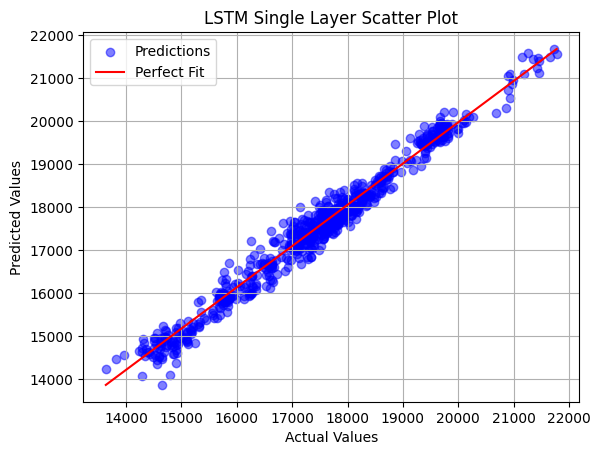

In [14]:
def plot_regression(y_true, y_pred):
  plt.scatter(y_test_actual_LSTM, predictions_LSTM, color='blue', alpha=0.5, label='Predictions')
  plt.plot([min(y_test_actual_LSTM), max(y_test_actual_LSTM)], [min(predictions_LSTM), max(predictions_LSTM)], color='red', linestyle='-', label='Perfect Fit')
  plt.xlabel('Actual Values')
  plt.ylabel('Predicted Values')
  plt.title('LSTM Single Layer Scatter Plot')
  plt.legend()
  plt.grid(True)
  plt.savefig('Scatterplot_LSTM1.png', dpi=600)
  plt.show()

#Scatter plot
plot_regression(y_test_actual_LSTM,predictions_LSTM)

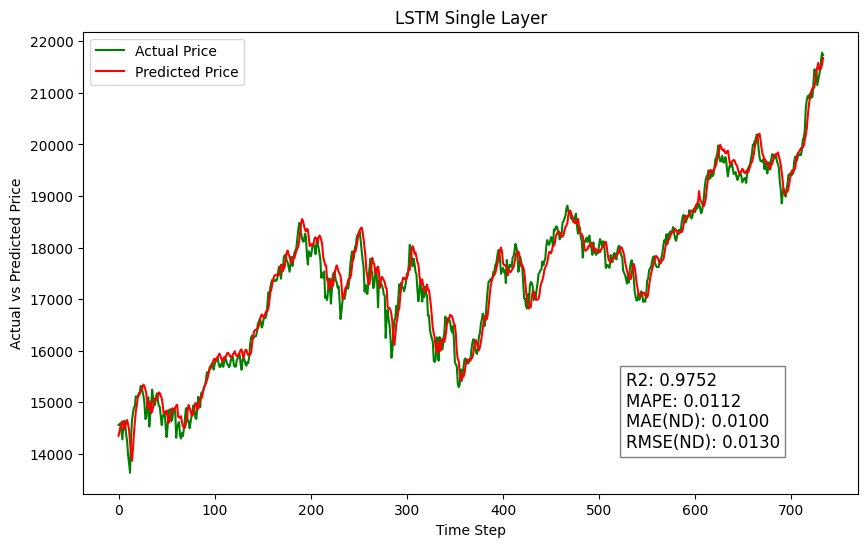

In [15]:
#plot prediction accuracy
plt.figure(figsize=(10, 6))
plt.plot(y_test_actual_LSTM, color='green', label=['Actual Price'])
plt.plot(predictions_LSTM, color='red', label=['Predicted Price'])
plt.legend(['Actual Price', 'Predicted Price'], loc='upper left')

plt.text(0.7, 0.1, f'R2: {r2:.4f}\nMAPE: {mape:.4f}\nMAE(ND): {mae_normalizeddata:.4f}\nRMSE(ND): {rmse_normalizeddata:.4f}',
         fontsize=12,
         bbox=dict(facecolor='white', alpha=0.5),
         transform=plt.gca().transAxes)

plt.title('LSTM Single Layer')
plt.xlabel('Time Step')
plt.ylabel('Actual vs Predicted Price')
plt.savefig('lstm1_0.9752.png', dpi=600)  # Saves the plot as a JPG file
plt.show()

In [16]:
#load saved GRU 1 layer best model
model_gru = load_model('model_ET_sp-usdinr_gru1_0.9775.keras')

model_gru.predict(X_test)
predictions_gru = model_gru.predict(X_test)
predictions_GRU = scaler.inverse_transform(predictions_gru)
y_test_actual_GRU = scaler.inverse_transform(y_test.reshape(-1, 1))

# Model's Accuracy Calculation 
r2=r2_score(y_test_actual_GRU, predictions_GRU)
print(f"R2: {r2:.4f}")
mape=mean_absolute_percentage_error(y_test_actual_GRU, predictions_GRU)
print(f"MAPE: {mape:.4f}")
mse=mean_squared_error(y_test_actual_GRU, predictions_GRU)
rmse=np.sqrt(mse)
print(f"RMSE: {rmse:.4f}")

mse_normalizeddata=mean_squared_error(y_test, predictions_gru)
rmse_normalizeddata=np.sqrt(mse_normalizeddata)
print(f"RMSE_normalizeddata: {rmse_normalizeddata:.4f}")

mae_normalizeddata=mean_absolute_error(y_test, predictions_gru)
print(f"MAE_normalizeddata: {mae_normalizeddata:.4f}")

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
R2: 0.9775
MAPE: 0.0107
RMSE: 236.9892
RMSE_normalizeddata: 0.0123
MAE_normalizeddata: 0.0095


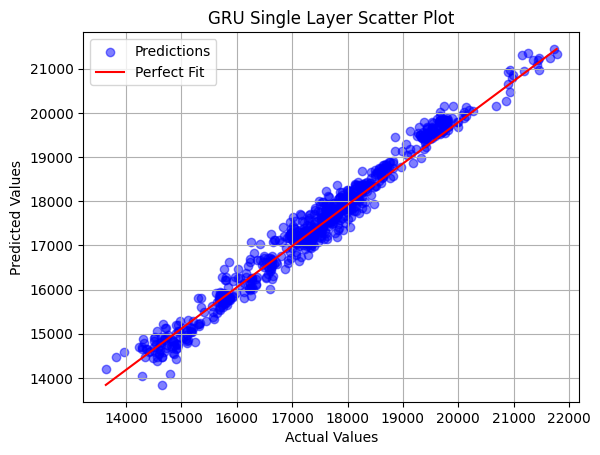

In [17]:
def plot_regression(y_true, y_pred):
  plt.scatter(y_test_actual_GRU, predictions_GRU, color='blue', alpha=0.5, label='Predictions')
  plt.plot([min(y_test_actual_GRU), max(y_test_actual_GRU)], [min(predictions_GRU), max(predictions_GRU)], color='red', linestyle='-', label='Perfect Fit')
  plt.xlabel('Actual Values')
  plt.ylabel('Predicted Values')
  plt.title('GRU Single Layer Scatter Plot')
  plt.legend()
  plt.grid(True)
  plt.savefig('Scatterplot_GRU1.png', dpi=600)
  plt.show()

#Scatter plot
plot_regression(y_test_actual_GRU,predictions_GRU)

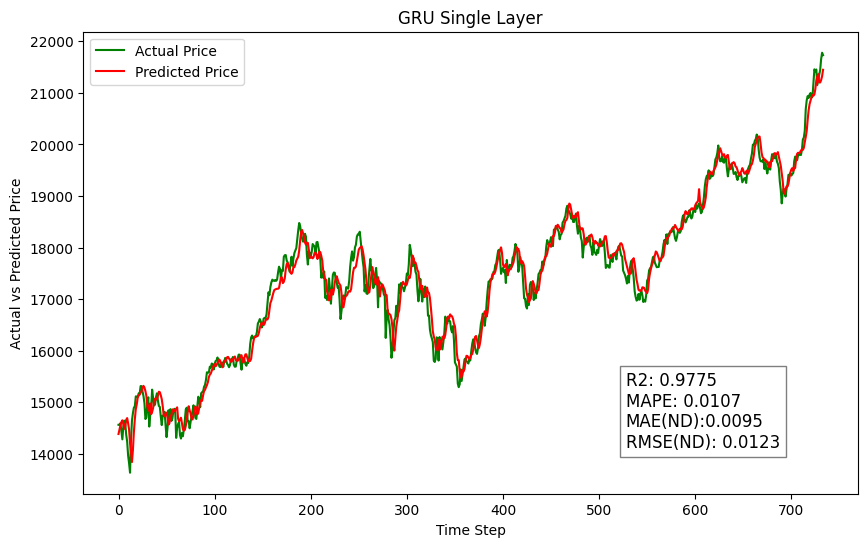

In [18]:
#plot prediction accuracy
plt.figure(figsize=(10, 6))
plt.plot(y_test_actual_GRU, color='green', label=['Actual Price'])
plt.plot(predictions_GRU, color='red', label=['Predicted Price'])
plt.legend(['Actual Price', 'Predicted Price'], loc='upper left')

plt.text(0.7, 0.1, f'R2: {r2:.4f}\nMAPE: {mape:.4f}\nMAE(ND):{mae_normalizeddata:.4f}\nRMSE(ND): {rmse_normalizeddata:.4f}', 
         fontsize=12, 
         bbox=dict(facecolor='white', alpha=0.5),
         transform=plt.gca().transAxes)

plt.title('GRU Single Layer')
plt.xlabel('Time Step')
plt.ylabel('Actual vs Predicted Price')
plt.savefig('gru1_0.9775.png', dpi=600) 
plt.show()

In [19]:
#load saved GRU-LSTM 1 layer best model
model_grulstm = load_model('model_ET_sp-usdinr_grulstm1_0.9797.keras')

model_grulstm.predict(X_test)
predictions_grulstm = model_grulstm.predict(X_test)
predictions_GRULSTM = scaler.inverse_transform(predictions_grulstm)
y_test_actual_GRULSTM = scaler.inverse_transform(y_test.reshape(-1, 1))

# Model's Accuracy Calculation 
r2=r2_score(y_test_actual_GRULSTM, predictions_GRULSTM)
print(f"R2: {r2:.4f}")

mape=mean_absolute_percentage_error(y_test_actual_GRULSTM, predictions_GRULSTM)
print(f"MAPE: {mape:.4f}")

mse=mean_squared_error(y_test_actual_GRULSTM, predictions_GRULSTM)
print(f"MSE: {mse:.4f}")

rmse=np.sqrt(mse)
print(f"RMSE: {rmse:.4f}")

mae_normalizeddata=mean_absolute_error(y_test, predictions_grulstm)
print(f"MAE_normalizeddata: {mae_normalizeddata:.4f}")

mse_n=mean_squared_error(y_test, predictions_grulstm)
rmse_n=np.sqrt(mse_n)
print(f"RMSE of Normalized Data: {rmse_n:.4f}")

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
R2: 0.9797
MAPE: 0.0103
MSE: 50791.9565
RMSE: 225.3707
MAE_normalizeddata: 0.0091
RMSE of Normalized Data: 0.0117


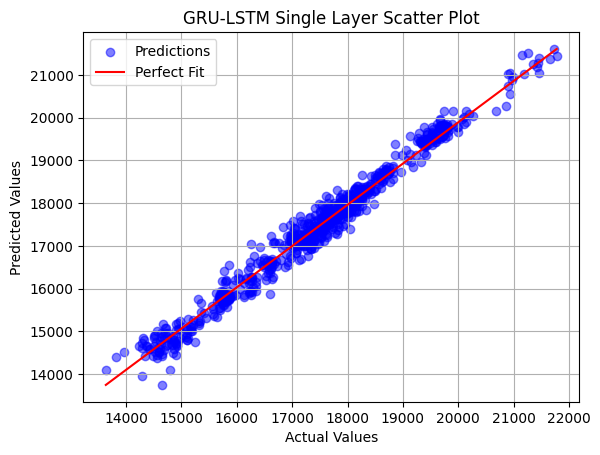

In [20]:
def plot_regression(y_true, y_pred):
  plt.scatter(y_test_actual_GRULSTM, predictions_GRULSTM, color='blue', alpha=0.5, label='Predictions')
  plt.plot([min(y_test_actual_GRULSTM), max(y_test_actual_GRULSTM)], [min(predictions_GRULSTM), max(predictions_GRULSTM)], color='red', linestyle='-', label='Perfect Fit')
  plt.xlabel('Actual Values')
  plt.ylabel('Predicted Values')
  plt.title('GRU-LSTM Single Layer Scatter Plot')
  plt.legend()
  plt.grid(True)
  plt.savefig('Scatterplot_GRULSTM1.png', dpi=600)
  plt.show()

#Scatter plot
plot_regression(y_test_actual_GRULSTM,predictions_GRULSTM)

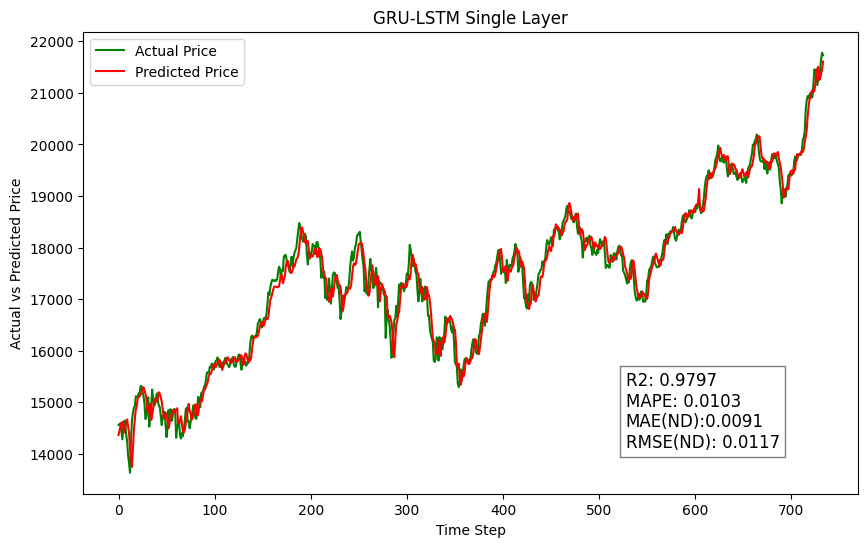

In [21]:
#plot prediction accuracy
plt.figure(figsize=(10, 6))
plt.plot(y_test_actual_GRULSTM, color='green', label=['Actual Price'])
plt.plot(predictions_GRULSTM, color='red', label=['Predicted Price'])
plt.legend(['Actual Price', 'Predicted Price'], loc='upper left')

plt.text(0.7, 0.1, f'R2: {r2:.4f}\nMAPE: {mape:.4f}\nMAE(ND):{mae_normalizeddata:.4f}\nRMSE(ND): {rmse_n:.4f}',
         fontsize=12,
         bbox=dict(facecolor='white', alpha=0.5),
         transform=plt.gca().transAxes)

plt.title('GRU-LSTM Single Layer')
plt.xlabel('Time Step')
plt.ylabel('Actual vs Predicted Price')
plt.savefig('grulstm1_0.9797.png', dpi=600) 
plt.show()

In [22]:
#load saved LSTM-GRU 1 layer best model
model_lstmgru = load_model('model_ET_sp-usdinr_lstmgru1_0.9697.keras')
model_lstmgru.predict(X_test)

predictions_lstmgru = model_lstmgru.predict(X_test)
predictions_LSTMGRU = scaler.inverse_transform(predictions_lstmgru)
y_test_actual_LSTMGRU = scaler.inverse_transform(y_test.reshape(-1, 1))

dates_test=df['Date'].iloc[split + n_steps:]

# Model's Accuracy Calculation 
r2=r2_score(y_test_actual_LSTMGRU, predictions_LSTMGRU)
print(f"R2: {r2:.4f}")

mape=mean_absolute_percentage_error(y_test_actual_LSTMGRU, predictions_LSTMGRU)
print(f"MAPE: {mape:.4f}")

mse=mean_squared_error(y_test_actual_LSTMGRU, predictions_LSTMGRU)
print(f"MSE: {mse:.4f}")
rmse=np.sqrt(mse)
print(f"RMSE: {rmse:.4f}")

mae=mean_absolute_error(y_test_actual_LSTMGRU, predictions_LSTMGRU)
print(f"MAE: {mae:.4f}")

mae_normalizeddata=mean_absolute_error(y_test, predictions_lstmgru)
print(f"MAE_normalizeddata: {mae_normalizeddata:.4f}")

mse_n=mean_squared_error(y_test, predictions_lstmgru)
rmse_n=np.sqrt(mse_n)
print(f"RMSE of Normalized Data: {rmse_n:.4f}")

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
R2: 0.9697
MAPE: 0.0126
MSE: 75721.8024
RMSE: 275.1759
MAE: 216.0939
MAE_normalizeddata: 0.0113
RMSE of Normalized Data: 0.0143


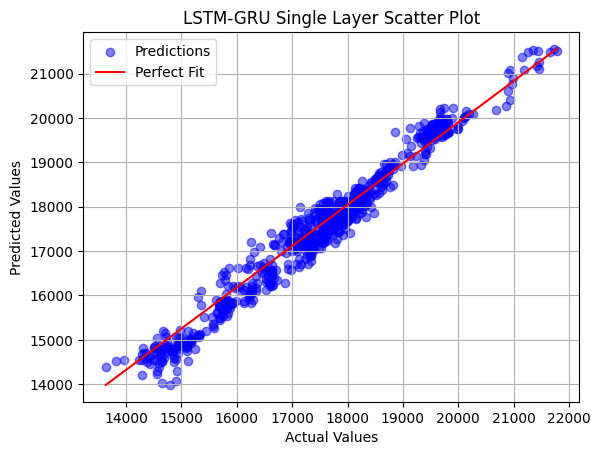

In [23]:
def plot_regression(y_true, y_pred):
  plt.scatter(y_test_actual_LSTMGRU, predictions_LSTMGRU, color='blue', alpha=0.5, label='Predictions')
  plt.plot([min(y_test_actual_LSTMGRU), max(y_test_actual_LSTMGRU)], [min(predictions_LSTMGRU), max(predictions_LSTMGRU)], color='red', linestyle='-', label='Perfect Fit')
  plt.xlabel('Actual Values')
  plt.ylabel('Predicted Values')
  plt.title('LSTM-GRU Single Layer Scatter Plot')
  plt.legend()
  plt.grid(True)
  plt.savefig('Scatterplot_LSTMGRU1.png', dpi=600)
  plt.show()

#Scatter plot
plot_regression(y_test_actual_LSTMGRU,predictions_LSTMGRU)

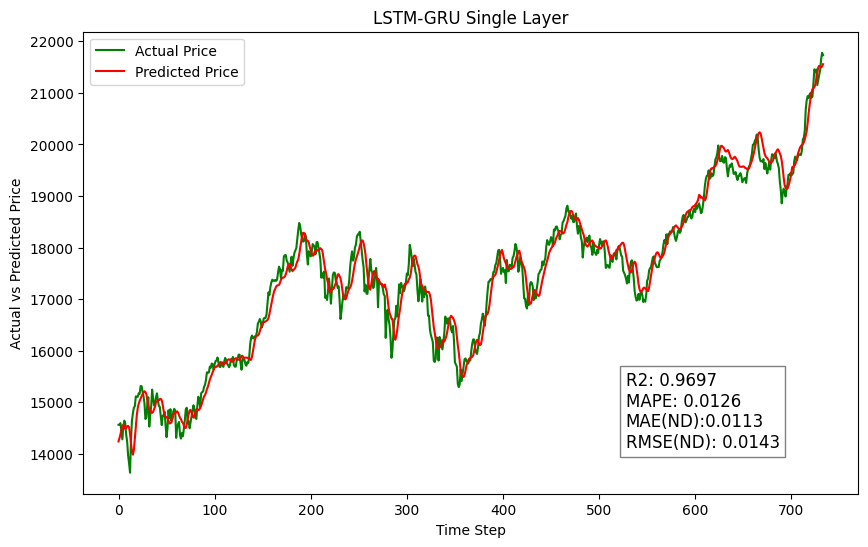

In [24]:
#plot prediction accuracy
plt.figure(figsize=(10, 6))
plt.plot(y_test_actual_LSTMGRU, color='green', label=['Actual Price'])
plt.plot(predictions_LSTMGRU, color='red', label=['Predicted Price'])
plt.legend(['Actual Price', 'Predicted Price'], loc='upper left')

plt.text(0.7, 0.1, f'R2: {r2:.4f}\nMAPE: {mape:.4f}\nMAE(ND):{mae_normalizeddata:.4f}\nRMSE(ND): {rmse_n:.4f}',
         fontsize=12,
         bbox=dict(facecolor='white', alpha=0.5),
         transform=plt.gca().transAxes)

plt.title('LSTM-GRU Single Layer')
plt.xlabel('Time Step')
plt.ylabel('Actual vs Predicted Price')
plt.savefig('lstmgru1_0.9697.png', dpi=600)  
plt.show()

In [25]:
#load saved LSTM 2 layer best model
model_lstm = load_model('model_ET_sp-usdinr_lstm2_0.9725.keras')

model_lstm.predict(X_test)
predictions_lstm = model_lstm.predict(X_test)
predictions_LSTM = scaler.inverse_transform(predictions_lstm)
y_test_actual_LSTM = scaler.inverse_transform(y_test.reshape(-1, 1))

# Model's Accuracy Calculation 
r2=r2_score(y_test_actual_LSTM, predictions_LSTM)
print(f"R2: {r2:.4f}")

mape=mean_absolute_percentage_error(y_test_actual_LSTM, predictions_LSTM)
print(f"MAPE: {mape:.4f}")

mse=mean_squared_error(y_test_actual_LSTM, predictions_LSTM)
rmse=np.sqrt(mse)
print(f"RMSE: {rmse:.4f}")

mse_normalizeddata=mean_squared_error(y_test, predictions_lstm)
rmse_normalizeddata=np.sqrt(mse_normalizeddata)
print(f"RMSE_normalizeddata: {rmse_normalizeddata:.4f}")

mae=mean_absolute_error(y_test_actual_LSTM, predictions_LSTM)
print(f"MAE: {mae:.4f}")

mae_normalizeddata=mean_absolute_error(y_test, predictions_lstm)
print(f"MAE_normalizeddata: {mae_normalizeddata:.4f}")

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
R2: 0.9725
MAPE: 0.0121
RMSE: 261.9136
RMSE_normalizeddata: 0.0136
MAE: 210.6815
MAE_normalizeddata: 0.0110


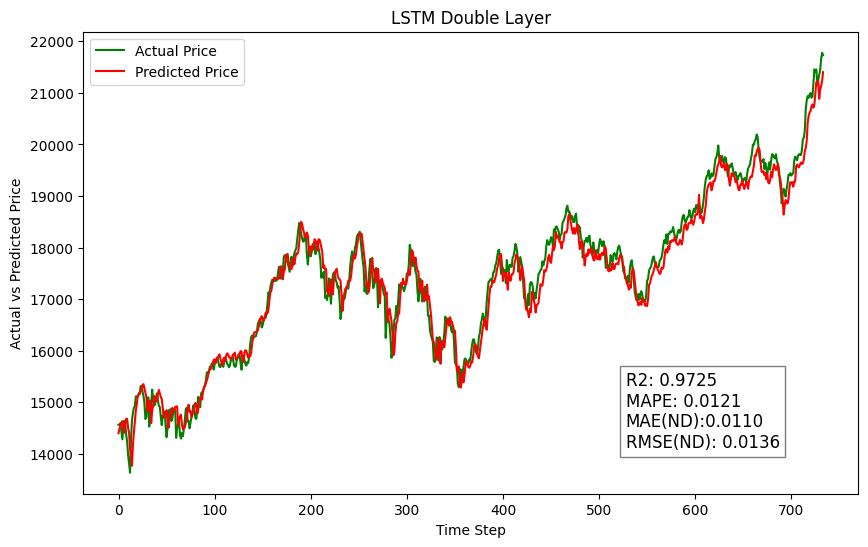

In [26]:
#plot prediction accuracy
plt.figure(figsize=(10, 6))
plt.plot(y_test_actual_LSTM, color='green', label=['Actual Price'])
plt.plot(predictions_LSTM, color='red', label=['Predicted Price'])
plt.legend(['Actual Price', 'Predicted Price'], loc='upper left')

plt.text(0.7, 0.1, f'R2: {r2:.4f}\nMAPE: {mape:.4f}\nMAE(ND):{mae_normalizeddata:.4f}\nRMSE(ND): {rmse_normalizeddata:.4f}',
         fontsize=12,
         bbox=dict(facecolor='white', alpha=0.5),
         transform=plt.gca().transAxes)

plt.title('LSTM Double Layer')
plt.xlabel('Time Step')
plt.ylabel('Actual vs Predicted Price')
plt.savefig('lstm2_0.9725.png', dpi=600)  
plt.show()

In [27]:
#load saved GRU 2 layer best model
model_gru = load_model('model_ET_sp-usdinr_gru2_0.9626.keras')

model_gru.predict(X_test)
predictions_gru = model_gru.predict(X_test)
predictions_GRU = scaler.inverse_transform(predictions_gru)
y_test_actual_GRU = scaler.inverse_transform(y_test.reshape(-1, 1))

# Model's Accuracy Calculation 
r2=r2_score(y_test_actual_GRU, predictions_GRU)
print(f"R2: {r2:.4f}")
mape=mean_absolute_percentage_error(y_test_actual_GRU, predictions_GRU)
print(f"MAPE: {mape:.4f}")
mse=mean_squared_error(y_test_actual_GRU, predictions_GRU)
rmse=np.sqrt(mse)
print(f"RMSE: {rmse:.4f}")
mse_normalizeddata=mean_squared_error(y_test, predictions_gru)
rmse_normalizeddata=np.sqrt(mse_normalizeddata)
print(f"RMSE_normalizeddata: {rmse_normalizeddata:.4f}")
mae=mean_absolute_error(y_test_actual_GRU, predictions_GRU)
print(f"MAE: {mae:.4f}")

mae_normalizeddata=mean_absolute_error(y_test, predictions_gru)
print(f"MAE_normalizeddata: {mae_normalizeddata:.4f}")

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
R2: 0.9626
MAPE: 0.0139
RMSE: 305.5973
RMSE_normalizeddata: 0.0159
MAE: 238.9930
MAE_normalizeddata: 0.0124


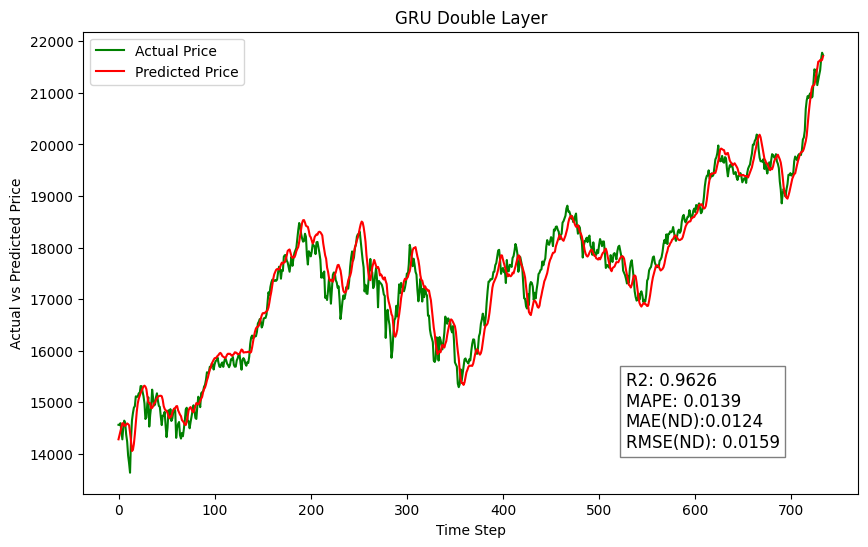

In [28]:
#plot prediction accuracy
plt.figure(figsize=(10, 6))
plt.plot(y_test_actual_GRU, color='green', label=['Actual Price'])
plt.plot(predictions_GRU, color='red', label=['Predicted Price'])
plt.legend(['Actual Price', 'Predicted Price'], loc='upper left')

plt.text(0.7, 0.1, f'R2: {r2:.4f}\nMAPE: {mape:.4f}\nMAE(ND):{mae_normalizeddata:.4f}\nRMSE(ND): {rmse_normalizeddata:.4f}', 
         fontsize=12, 
         bbox=dict(facecolor='white', alpha=0.5),
         transform=plt.gca().transAxes)

plt.title('GRU Double Layer')
plt.xlabel('Time Step')
plt.ylabel('Actual vs Predicted Price')
plt.savefig('gru2_0.9626.png', dpi=600)  
plt.show()

In [29]:
#load saved GRU-LSTM 2 layer best model
model_grulstm = load_model('model_ET_sp-usdinr_grulstm2_0.9594.keras')

model_grulstm.predict(X_test)
predictions_grulstm = model_grulstm.predict(X_test)
predictions_GRULSTM = scaler.inverse_transform(predictions_grulstm)
y_test_actual_GRULSTM = scaler.inverse_transform(y_test.reshape(-1, 1))

# Model's Accuracy Calculation 
r2=r2_score(y_test_actual_GRULSTM, predictions_GRULSTM)
print(f"R2: {r2:.4f}")

mape=mean_absolute_percentage_error(y_test_actual_GRULSTM, predictions_GRULSTM)
print(f"MAPE: {mape:.4f}")

mse=mean_squared_error(y_test_actual_GRULSTM, predictions_GRULSTM)
print(f"MSE: {mse:.4f}")
rmse=np.sqrt(mse)
print(f"RMSE: {rmse:.4f}")

mae=mean_absolute_error(y_test_actual_GRULSTM, predictions_GRULSTM)
print(f"MAE: {mae:.4f}")

mae_normalizeddata=mean_absolute_error(y_test, predictions_grulstm)
print(f"MAE_normalizeddata: {mae_normalizeddata:.4f}")

mse_n=mean_squared_error(y_test, predictions_grulstm)
rmse_n=np.sqrt(mse_n)
print(f"RMSE of Normalized Data: {rmse_n:.4f}")

23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
R2: 0.9594
MAPE: 0.0147
MSE: 101490.8130
RMSE: 318.5762
MAE: 253.1295
MAE_normalizeddata: 0.0132
RMSE of Normalized Data: 0.0166


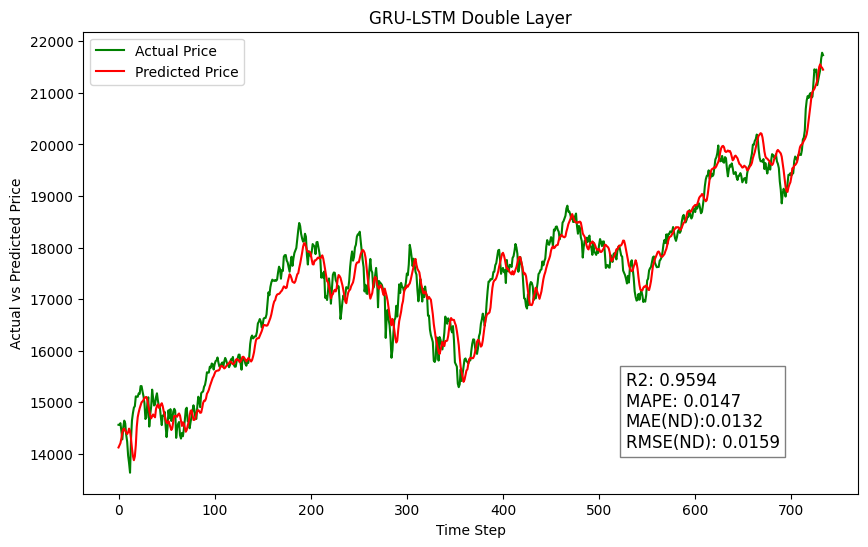

In [30]:
#plot prediction accuracy
plt.figure(figsize=(10, 6))
plt.plot(y_test_actual_GRULSTM, color='green', label=['Actual Price'])
plt.plot(predictions_GRULSTM, color='red', label=['Predicted Price'])
plt.legend(['Actual Price', 'Predicted Price'], loc='upper left')

plt.text(0.7, 0.1, f'R2: {r2:.4f}\nMAPE: {mape:.4f}\nMAE(ND):{mae_normalizeddata:.4f}\nRMSE(ND): {rmse_normalizeddata:.4f}',
         fontsize=12,
         bbox=dict(facecolor='white', alpha=0.5),
         transform=plt.gca().transAxes)

plt.title('GRU-LSTM Double Layer')
plt.xlabel('Time Step')
plt.ylabel('Actual vs Predicted Price')
plt.savefig('grulstm2_0.9594.png', dpi=600)  
plt.show()

In [31]:
#load saved LSTM-GRU 2 layer best model
model_lstmgru = load_model('model_ET_sp-usdinr_lstmgru2_0.9512.keras')

model_lstmgru.predict(X_test)
predictions_lstmgru = model_lstmgru.predict(X_test)
predictions_LSTMGRU = scaler.inverse_transform(predictions_lstmgru)
y_test_actual_LSTMGRU = scaler.inverse_transform(y_test.reshape(-1, 1))

dates_test=df['Date'].iloc[split + n_steps:]

# Model's Accuracy Calculation 
r2=r2_score(y_test_actual_LSTMGRU, predictions_LSTMGRU)
print(f"R2: {r2:.4f}")

mape=mean_absolute_percentage_error(y_test_actual_LSTMGRU, predictions_LSTMGRU)
print(f"MAPE: {mape:.4f}")

mse=mean_squared_error(y_test_actual_LSTMGRU, predictions_LSTMGRU)
print(f"MSE: {mse:.4f}")
rmse=np.sqrt(mse)
print(f"RMSE: {rmse:.4f}")

mae=mean_absolute_error(y_test_actual_LSTMGRU, predictions_LSTMGRU)
print(f"MAE: {mae:.4f}")

mae_normalizeddata=mean_absolute_error(y_test, predictions_lstmgru)
print(f"MAE_normalizeddata: {mae_normalizeddata:.4f}")

mse_n=mean_squared_error(y_test, predictions_lstmgru)
rmse_n=np.sqrt(mse_n)
print(f"RMSE of Normalized Data: {rmse_n:.4f}")

23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
R2: 0.9512
MAPE: 0.0165
MSE: 121956.1952
RMSE: 349.2223
MAE: 283.9021
MAE_normalizeddata: 0.0148
RMSE of Normalized Data: 0.0182


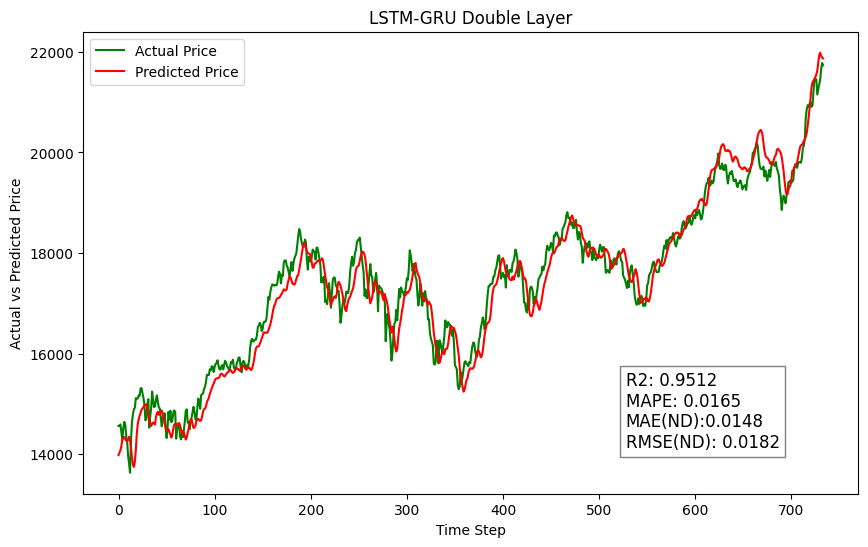

In [32]:
#plot prediction accuracy
plt.figure(figsize=(10, 6))
plt.plot(y_test_actual_LSTMGRU, color='green', label=['Actual Price'])
plt.plot(predictions_LSTMGRU, color='red', label=['Predicted Price'])
plt.legend(['Actual Price', 'Predicted Price'], loc='upper left')

plt.text(0.7, 0.1, f'R2: {r2:.4f}\nMAPE: {mape:.4f}\nMAE(ND):{mae_normalizeddata:.4f}\nRMSE(ND): {rmse_n:.4f}',
         fontsize=12,
         bbox=dict(facecolor='white', alpha=0.5),
         transform=plt.gca().transAxes)

plt.title('LSTM-GRU Double Layer')
plt.xlabel('Time Step')
plt.ylabel('Actual vs Predicted Price')
plt.savefig('lstmgru2_0.9512.png', dpi=600)  
plt.show()

In [33]:
#load saved LSTM 3 layer best model
model_lstm = load_model('model_ET_sp-usdinr_lstm3_0.9501.keras')

model_lstm.predict(X_test)
predictions_lstm = model_lstm.predict(X_test)
predictions_LSTM = scaler.inverse_transform(predictions_lstm)
y_test_actual_LSTM = scaler.inverse_transform(y_test.reshape(-1, 1))

# Model's Accuracy Calculation 
r2=r2_score(y_test_actual_LSTM, predictions_LSTM)
print(f"R2: {r2:.4f}")

mape=mean_absolute_percentage_error(y_test_actual_LSTM, predictions_LSTM)
print(f"MAPE: {mape:.4f}")

mse=mean_squared_error(y_test_actual_LSTM, predictions_LSTM)
rmse=np.sqrt(mse)
print(f"RMSE: {rmse:.4f}")

mse_normalizeddata=mean_squared_error(y_test, predictions_lstm)
rmse_normalizeddata=np.sqrt(mse_normalizeddata)
print(f"RMSE_normalizeddata: {rmse_normalizeddata:.4f}")

mae=mean_absolute_error(y_test_actual_LSTM, predictions_LSTM)
print(f"MAE: {mae:.4f}")

mae_normalizeddata=mean_absolute_error(y_test, predictions_lstm)
print(f"MAE_normalizeddata: {mae_normalizeddata:.4f}")

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
R2: 0.9501
MAPE: 0.0159
RMSE: 353.0404
RMSE_normalizeddata: 0.0184
MAE: 274.5176
MAE_normalizeddata: 0.0143


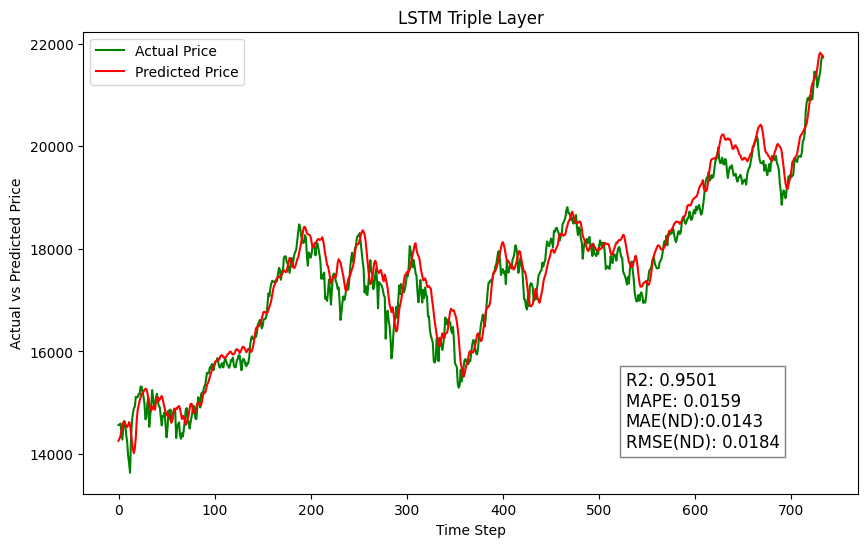

In [34]:
#plot prediction accuracy
plt.figure(figsize=(10, 6))
plt.plot(y_test_actual_LSTM, color='green', label=['Actual Price'])
plt.plot(predictions_LSTM, color='red', label=['Predicted Price'])
plt.legend(['Actual Price', 'Predicted Price'], loc='upper left')

plt.text(0.7, 0.1, f'R2: {r2:.4f}\nMAPE: {mape:.4f}\nMAE(ND):{mae_normalizeddata:.4f}\nRMSE(ND): {rmse_normalizeddata:.4f}',
         fontsize=12,
         bbox=dict(facecolor='white', alpha=0.5),
         transform=plt.gca().transAxes)

plt.title('LSTM Triple Layer')
plt.xlabel('Time Step')
plt.ylabel('Actual vs Predicted Price')
plt.savefig('lstm3_0.9501.png', dpi=600)  
plt.show()

In [35]:
#load saved GRU 3 layer best model
model_gru = load_model('model_ET_sp-usdinr_gru3_0.9745.keras')

model_gru.predict(X_test)
predictions_gru = model_gru.predict(X_test)
predictions_GRU = scaler.inverse_transform(predictions_gru)
y_test_actual_GRU = scaler.inverse_transform(y_test.reshape(-1, 1))

# Model's Accuracy Calculation 
r2=r2_score(y_test_actual_GRU, predictions_GRU)
print(f"R2: {r2:.4f}")
mape=mean_absolute_percentage_error(y_test_actual_GRU, predictions_GRU)
print(f"MAPE: {mape:.4f}")
mse=mean_squared_error(y_test_actual_GRU, predictions_GRU)
rmse=np.sqrt(mse)
print(f"RMSE: {rmse:.4f}")
mse_normalizeddata=mean_squared_error(y_test, predictions_gru)
rmse_normalizeddata=np.sqrt(mse_normalizeddata)
print(f"RMSE_normalizeddata: {rmse_normalizeddata:.4f}")
mae=mean_absolute_error(y_test_actual_GRU, predictions_GRU)
print(f"MAE: {mae:.4f}")

mae_normalizeddata=mean_absolute_error(y_test, predictions_gru)
print(f"MAE_normalizeddata: {mae_normalizeddata:.4f}")

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
R2: 0.9745
MAPE: 0.0114
RMSE: 252.4886
RMSE_normalizeddata: 0.0131
MAE: 195.7010
MAE_normalizeddata: 0.0102


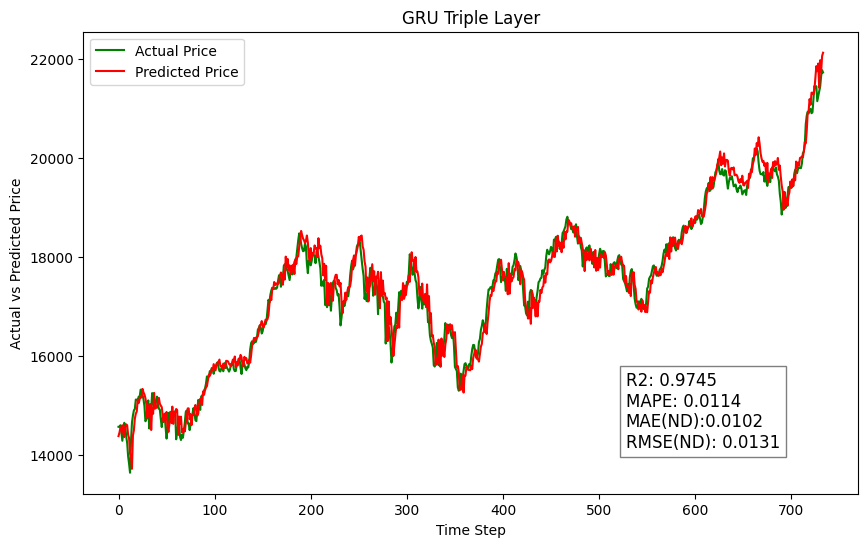

In [36]:
plt.figure(figsize=(10, 6))
plt.plot(y_test_actual_GRU, color='green', label=['Actual Price'])
plt.plot(predictions_GRU, color='red', label=['Predicted Price'])
plt.legend(['Actual Price', 'Predicted Price'], loc='upper left')

plt.text(0.7, 0.1, f'R2: {r2:.4f}\nMAPE: {mape:.4f}\nMAE(ND):{mae_normalizeddata:.4f}\nRMSE(ND): {rmse_normalizeddata:.4f}',
         fontsize=12,
         bbox=dict(facecolor='white', alpha=0.5),
         transform=plt.gca().transAxes)

plt.title('GRU Triple Layer')
plt.xlabel('Time Step')
plt.ylabel('Actual vs Predicted Price')
plt.savefig('gru3_0.9745.png', dpi=600)  
plt.show()

In [47]:
#load saved GRU-LSTM 3 layer best model
model_grulstm = load_model('model_ET_sp-usdinr_grulstm3_0.9396.keras')

model_grulstm.predict(X_test)
predictions_grulstm = model_grulstm.predict(X_test)
predictions_GRULSTM = scaler.inverse_transform(predictions_grulstm)
y_test_actual_GRULSTM = scaler.inverse_transform(y_test.reshape(-1, 1))
dates_test=df['Date'].iloc[split + n_steps:]

# Model's Accuracy Calculation 
r2=r2_score(y_test_actual_GRULSTM, predictions_GRULSTM)
print(f"R2: {r2:.4f}")
mape=mean_absolute_percentage_error(y_test_actual_GRULSTM, predictions_GRULSTM)
print(f"MAPE: {mape:.4f}")
mse=mean_squared_error(y_test_actual_GRULSTM, predictions_GRULSTM)
print(f"MSE: {mse:.4f}")
rmse=np.sqrt(mse)
print(f"RMSE: {rmse:.4f}")
mae=mean_absolute_error(y_test_actual_GRULSTM, predictions_GRULSTM)
print(f"MAE: {mae:.4f}")

mae_normalizeddata=mean_absolute_error(y_test, predictions_grulstm)
print(f"MAE_normalizeddata: {mae_normalizeddata:.4f}")

mse_normalizeddata=mean_squared_error(y_test, predictions_grulstm)
rmse_normalizeddata=np.sqrt(mse_normalizeddata)
print(f"RMSE of Normalized Data: {rmse_normalizeddata:.4f}")

23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 77ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
R2: 0.9396
MAPE: 0.0180
MSE: 150938.9852
RMSE: 388.5087
MAE: 312.7509
MAE_normalizeddata: 0.0163
RMSE of Normalized Data: 0.0202


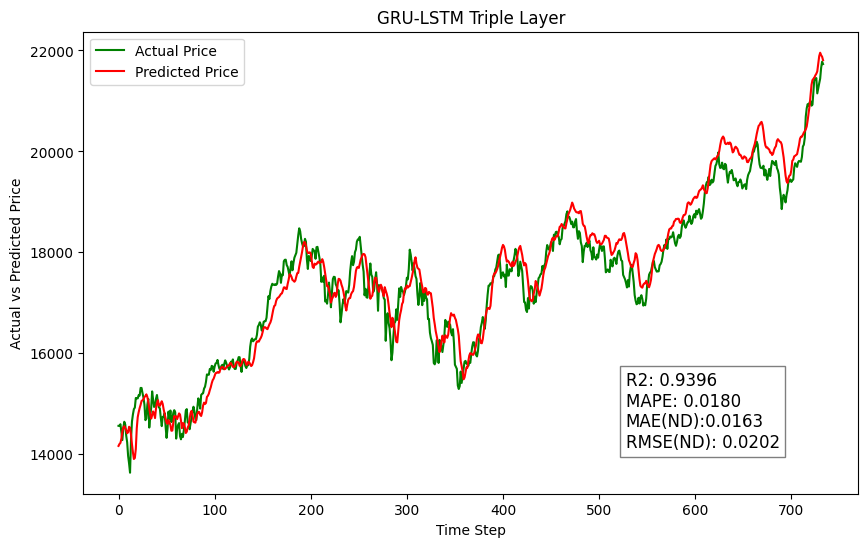

In [48]:
#plot prediction accuracy
plt.figure(figsize=(10, 6))
plt.plot(y_test_actual_GRULSTM, color='green', label=['Actual Price'])
plt.plot(predictions_GRULSTM, color='red', label=['Predicted Price'])
plt.legend(['Actual Price', 'Predicted Price'], loc='upper left')

plt.text(0.7, 0.1, f'R2: {r2:.4f}\nMAPE: {mape:.4f}\nMAE(ND):{mae_normalizeddata:.4f}\nRMSE(ND): {rmse_normalizeddata:.4f}',
         fontsize=12,
         bbox=dict(facecolor='white', alpha=0.5),
         transform=plt.gca().transAxes)

plt.title('GRU-LSTM Triple Layer')
plt.xlabel('Time Step')
plt.ylabel('Actual vs Predicted Price')
plt.savefig('grulstm3_0.9396.png', dpi=600) 
plt.show()

In [50]:
#load saved LSTM-GRU 3 layer best model
model_lstmgru = load_model('model_ET_sp-usdinr_lstmgru3_0.9420.keras')

model_lstmgru.predict(X_test)
predictions_lstmgru = model_lstmgru.predict(X_test)
predictions_LSTMGRU = scaler.inverse_transform(predictions_lstmgru)
y_test_actual_LSTMGRU = scaler.inverse_transform(y_test.reshape(-1, 1))
dates_test=df['Date'].iloc[split + n_steps:]

# Model's Accuracy Calculation 
r2=r2_score(y_test_actual_LSTMGRU, predictions_LSTMGRU)
print(f"R2: {r2:.4f}")

mape=mean_absolute_percentage_error(y_test_actual_LSTMGRU, predictions_LSTMGRU)
print(f"MAPE: {mape:.4f}")

mse=mean_squared_error(y_test_actual_LSTMGRU, predictions_LSTMGRU)
print(f"MSE: {mse:.4f}")
rmse=np.sqrt(mse)
print(f"RMSE: {rmse:.4f}")

mae=mean_absolute_error(y_test_actual_LSTMGRU, predictions_LSTMGRU)
print(f"MAE: {mae:.4f}")

mae_normalizeddata=mean_absolute_error(y_test, predictions_lstmgru)
print(f"MAE_normalizeddata: {mae_normalizeddata:.4f}")

mse_normalizeddata=mean_squared_error(y_test, predictions_lstmgru)
rmse_normalizeddata=np.sqrt(mse_normalizeddata)
print(f"RMSE of Normalized Data: {rmse_normalizeddata:.4f}")

23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 90ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
R2: 0.9420
MAPE: 0.0176
MSE: 144870.1567
RMSE: 380.6181
MAE: 306.0309
MAE_normalizeddata: 0.0159
RMSE of Normalized Data: 0.0198


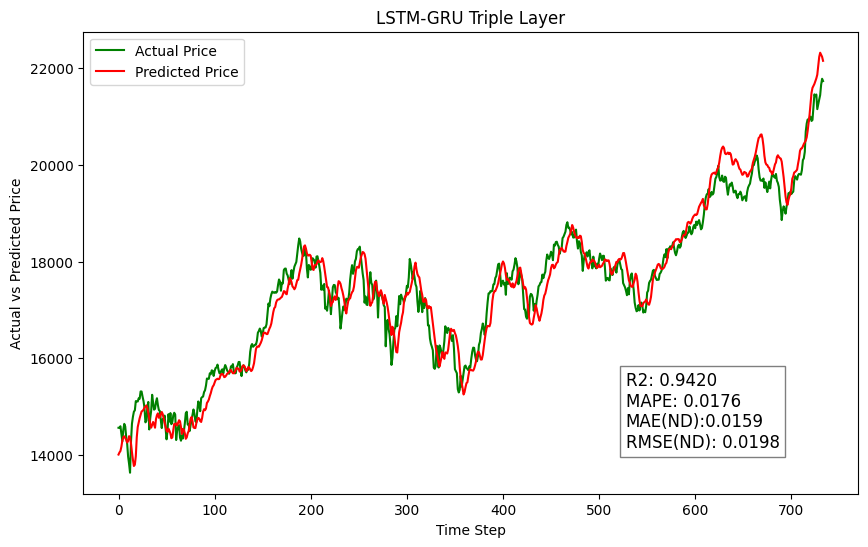

In [52]:
#plot prediction accuracy
plt.figure(figsize=(10, 6))
plt.plot(y_test_actual_LSTMGRU, color='green', label=['Actual Price'])
plt.plot(predictions_LSTMGRU, color='red', label=['Predicted Price'])
plt.legend(['Actual Price', 'Predicted Price'], loc='upper left')

plt.text(0.7, 0.1, f'R2: {r2:.4f}\nMAPE: {mape:.4f}\nMAE(ND):{mae_normalizeddata:.4f}\nRMSE(ND): {rmse_normalizeddata:.4f}',
         fontsize=12,
         bbox=dict(facecolor='white', alpha=0.5),
         transform=plt.gca().transAxes)

plt.title('LSTM-GRU Triple Layer')
plt.xlabel('Time Step')
plt.ylabel('Actual vs Predicted Price')
plt.savefig('lstmgru3_0.9420.png', dpi=600)  
plt.show()